In [1]:
import torch
import torchaudio
from supervoice_enhance.model import EnhanceModel
from supervoice_enhance.wrapper import SuperVoiceEnhance
from supervoice_enhance.config import config
from supervoice_enhance.audio import spectogram
from IPython.display import Audio, display
import matplotlib.pyplot as plt

# Loading model

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.hub.load(repo_or_dir='ex3ndr/supervoice-enhance', model='enhance', force_reload = True)
model.to(device)
model.eval()
print("OK")

# device = "cpu"
# flow = torch.hub.load(repo_or_dir='ex3ndr/supervoice-flow', model='flow')
# vocoder = torch.hub.load(repo_or_dir='ex3ndr/supervoice-vocoder', model='bigvsan')
# model = SuperVoiceEnhance(flow, vocoder)
# checkpoint = torch.load(f'./output/ft-08.pt', map_location="cpu")
# model.diffusion.load_state_dict(checkpoint['model'])
# model.to(device)
# model.eval()
# print("OK")

Downloading: "https://github.com/ex3ndr/supervoice-enhance/zipball/main" to /home/steve/.cache/torch/hub/main.zip
Using cache found in /home/steve/.cache/torch/hub/ex3ndr_supervoice-flow_main


OK


# Loading file
Provide custom file or try the sample

In [3]:
from ipywidgets import FileUpload
upload = FileUpload(multiple=False)
upload

FileUpload(value=(), description='Upload')

In [4]:
def load_mono_audio(path):
    # Load audio
    audio, sr = torchaudio.load(path)

    # Resample
    if sr != model.sample_rate:
        audio = torchaudio.transforms.Resample(sr, model.sample_rate)(audio)
        sr = model.sample_rate

    # Convert to mono
    if audio.shape[0] > 1:
        audio = audio.mean(dim=0, keepdim=True)

    # Convert to single dimension
    audio = audio[0]

    return audio

# Load
if len(upload.value) == 1:
    with open("eval.out", "w+b") as i:
        i.write(upload.value[0].content)
    source = load_mono_audio("eval.out")
else:
    source = load_mono_audio("./eval/eval_2.wav")

# Cut 5 seconds
target_length = 5 * model.sample_rate
current_length = source.shape[0]
padding_length = target_length - current_length
source = torch.nn.functional.pad(source, (0, padding_length), mode='constant')

# Play audio
display(Audio(data=source, rate=model.sample_rate))

# Enhance

In [5]:
# Enhance waveform
enhanced_8_step = model.enhance(waveform = source, steps = 8)
enhanced_32_step = model.enhance(waveform = source, steps = 32)

# Play audio
display(Audio(data=enhanced_8_step, rate=model.sample_rate))
display(Audio(data=enhanced_32_step, rate=model.sample_rate))

torch.Size([100, 468])
torch.Size([1, 119808])
torch.Size([119808])
torch.Size([100, 468])
torch.Size([1, 119808])
torch.Size([119808])


torch.Size([100, 468])


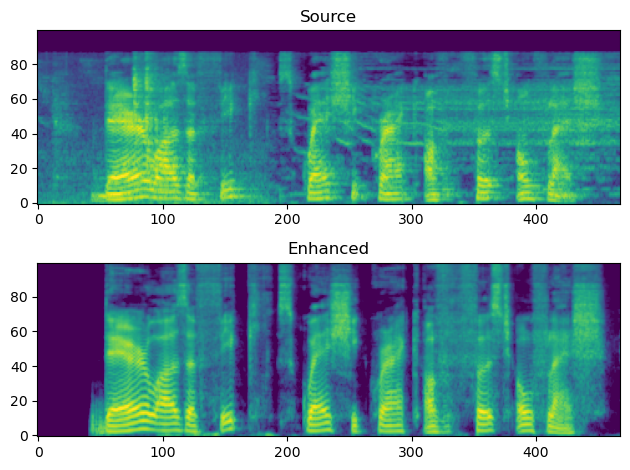

In [6]:
# Enhance spectogram directly

spec = spectogram(source, 
                  config.audio.n_fft, 
                  config.audio.n_mels, 
                  config.audio.hop_size, 
                  config.audio.win_size, 
                  config.audio.mel_norm, 
                  config.audio.mel_scale, 
                  config.audio.sample_rate
                 )
enhanced_spec = model.enhance(spec = spec, steps = 8, vocoder = False)
print(enhanced_spec.shape)

# Show spectogram
_, axis = plt.subplots(2, 1)
axis[0].imshow(spec, cmap="viridis", vmin=-10, vmax=0, origin="lower", aspect="auto")
axis[0].set_title("Source")
axis[1].imshow(enhanced_spec, cmap="viridis", vmin=-10, vmax=0, origin="lower", aspect="auto")
axis[1].set_title("Enhanced")
plt.tight_layout()